# Use `Folder` for Customs Datasets

# Installing Anomalib

The easiest way to install anomalib is to use pip. You can install it from the command line using the following command:


In [ ]:
%pip install anomalib

## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [6]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent / "datasets" / "hazelnut_toy"
dataset_root = Path("/home/djameln/anomalib/datasets/hazelnut_toy")

## Use Folder Dataset (for Custom Datasets) via API

Here we show how one can utilize custom datasets to train anomalib models. A custom dataset in this model can be of the following types:

- A dataset with good and bad images.
- A dataset with good and bad images as well as mask ground-truths for pixel-wise evaluation.
- A dataset with good and bad images that is already split into training and testing sets.

To experiment this setting we provide a toy dataset that could be downloaded from the following [https://github.com/openvinotoolkit/anomalib/blob/main/docs/source/data/hazelnut_toy.zip](link). For the rest of the tutorial, we assume that the dataset is downloaded and extracted to `../datasets`, located in the `anomalib` directory.


In [4]:
# flake8: noqa
import numpy as np
from PIL import Image
from torchvision.transforms.v2 import Resize
from torchvision.transforms.v2.functional import to_pil_image

from anomalib.data.image.folder import Folder, FolderDataset
from anomalib import TaskType

### DataModule

Similar to how we created the datamodules for existing benchmarking datasets in the previous tutorials, we can also create an Anomalib datamodule for our custom hazelnut dataset.

In addition to the root folder of the dataset, we now also specify which folder contains the normal images, which folder contains the anomalous images, and which folder contains the ground truth masks for the anomalous images.


In [7]:
folder_datamodule = Folder(
    name="hazelnut_toy",
    root=dataset_root,
    normal_dir="good",
    abnormal_dir="crack",
    task=TaskType.SEGMENTATION,
    mask_dir=dataset_root / "mask" / "crack",
    image_size=(256, 256),
)
folder_datamodule.setup()

In [9]:
# Train images
i, data = next(enumerate(folder_datamodule.train_dataloader()))
print(data.image.shape)

torch.Size([28, 3, 256, 256])


In [10]:
# Test images
i, data = next(enumerate(folder_datamodule.test_dataloader()))
print(data.image.shape, data.gt_mask.shape)

torch.Size([6, 3, 256, 256]) torch.Size([6, 256, 256])


As can be seen above, creating the dataloaders are pretty straghtforward, which could be directly used for training/testing/inference. We could visualize samples from the dataloaders as well.


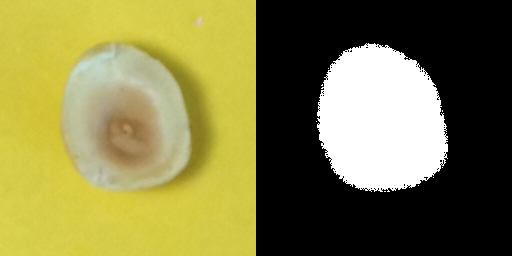

In [12]:
img = to_pil_image(data.image[0].clone())
msk = to_pil_image(data.gt_mask[0].int() * 255).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

`Folder` data module offers much more flexibility cater all different sorts of needs. Please refer to the documentation for more details.


### Torch Dataset

As in earlier examples, we can also create a standalone PyTorch dataset instance.


In [ ]:
FolderDataset??

We can add some transforms that will be applied to the images using torchvision. Let's add a transform that resizes the 
input image to 256x256 pixels.

In [13]:
image_size = (256, 256)
transform = Resize(image_size, antialias=True)

#### Classification Task


In [14]:
folder_dataset_classification_train = FolderDataset(
    name="hazelnut_toy",
    normal_dir=dataset_root / "good",
    abnormal_dir=dataset_root / "crack",
    split="train",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_train.samples.head()

,image_path,label,label_index,mask_path,split
0,/home/djameln/datasets/hazelnut_toy/good/00.jpg,DirType.NORMAL,0,,Split.TRAIN
1,/home/djameln/datasets/hazelnut_toy/good/01.jpg,DirType.NORMAL,0,,Split.TRAIN
2,/home/djameln/datasets/hazelnut_toy/good/02.jpg,DirType.NORMAL,0,,Split.TRAIN
3,/home/djameln/datasets/hazelnut_toy/good/03.jpg,DirType.NORMAL,0,,Split.TRAIN
4,/home/djameln/datasets/hazelnut_toy/good/04.jpg,DirType.NORMAL,0,,Split.TRAIN


Let's look at the first sample in the dataset.


In [15]:
data = folder_dataset_classification_train[0]
print(data.image.shape)

torch.Size([3, 256, 256])


As can be seen above, when we choose `classification` task and `train` split, the dataset only returns `image`. This is mainly because training only requires normal images and no labels. Now let's try `test` split for the `classification` task


In [16]:
# Folder Classification Test Set
folder_dataset_classification_test = FolderDataset(
    name="hazelnut_toy",
    normal_dir=dataset_root / "good",
    abnormal_dir=dataset_root / "crack",
    split="test",
    transform=transform,
    task=TaskType.CLASSIFICATION,
)
folder_dataset_classification_test.samples.head()

,image_path,label,label_index,mask_path,split
0,/home/djameln/datasets/hazelnut_toy/crack/01.jpg,DirType.ABNORMAL,1,,Split.TEST
1,/home/djameln/datasets/hazelnut_toy/crack/02.jpg,DirType.ABNORMAL,1,,Split.TEST
2,/home/djameln/datasets/hazelnut_toy/crack/03.jpg,DirType.ABNORMAL,1,,Split.TEST
3,/home/djameln/datasets/hazelnut_toy/crack/04.jpg,DirType.ABNORMAL,1,,Split.TEST
4,/home/djameln/datasets/hazelnut_toy/crack/05.jpg,DirType.ABNORMAL,1,,Split.TEST


In [18]:
data = folder_dataset_classification_test[0]
print(data.image.shape, data.image_path, data.gt_label)

torch.Size([3, 256, 256]) /home/djameln/datasets/hazelnut_toy/crack/01.jpg tensor(True)


#### Segmentation Task

It is also possible to configure the Folder dataset for the segmentation task, where the dataset object returns image and ground-truth mask.


In [19]:
# Folder Segmentation Train Set
folder_dataset_segmentation_train = FolderDataset(
    name="hazelnut_toy",
    normal_dir=dataset_root / "good",
    abnormal_dir=dataset_root / "crack",
    split="train",
    transform=transform,
    mask_dir=dataset_root / "mask" / "crack",
    task=TaskType.SEGMENTATION,
)
folder_dataset_segmentation_train.samples.head()

,image_path,label,label_index,mask_path,split
0,/home/djameln/datasets/hazelnut_toy/good/00.jpg,DirType.NORMAL,0,,Split.TRAIN
1,/home/djameln/datasets/hazelnut_toy/good/01.jpg,DirType.NORMAL,0,,Split.TRAIN
2,/home/djameln/datasets/hazelnut_toy/good/02.jpg,DirType.NORMAL,0,,Split.TRAIN
3,/home/djameln/datasets/hazelnut_toy/good/03.jpg,DirType.NORMAL,0,,Split.TRAIN
4,/home/djameln/datasets/hazelnut_toy/good/04.jpg,DirType.NORMAL,0,,Split.TRAIN


In [20]:
# Folder Segmentation Test Set
folder_dataset_segmentation_test = FolderDataset(
    name="hazelnut_toy",
    normal_dir=dataset_root / "good",
    abnormal_dir=dataset_root / "crack",
    split="test",
    transform=transform,
    mask_dir=dataset_root / "mask" / "crack",
    task=TaskType.SEGMENTATION,
)
folder_dataset_segmentation_test.samples.head(10)

,image_path,label,label_index,mask_path,split
0,/home/djameln/datasets/hazelnut_toy/crack/01.jpg,DirType.ABNORMAL,1,/home/djameln/datasets/hazelnut_toy/mask/crack...,Split.TEST
1,/home/djameln/datasets/hazelnut_toy/crack/02.jpg,DirType.ABNORMAL,1,/home/djameln/datasets/hazelnut_toy/mask/crack...,Split.TEST
2,/home/djameln/datasets/hazelnut_toy/crack/03.jpg,DirType.ABNORMAL,1,/home/djameln/datasets/hazelnut_toy/mask/crack...,Split.TEST
3,/home/djameln/datasets/hazelnut_toy/crack/04.jpg,DirType.ABNORMAL,1,/home/djameln/datasets/hazelnut_toy/mask/crack...,Split.TEST
4,/home/djameln/datasets/hazelnut_toy/crack/05.jpg,DirType.ABNORMAL,1,/home/djameln/datasets/hazelnut_toy/mask/crack...,Split.TEST


In [21]:
data = folder_dataset_segmentation_test[3]
print(data.image.shape, data.gt_mask.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


Let's visualize the image and the mask...


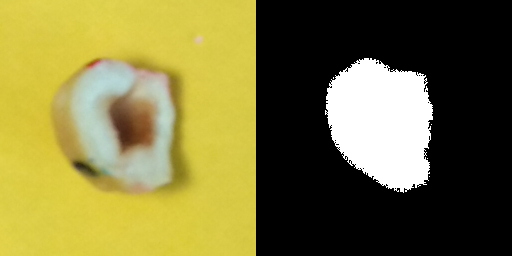

In [24]:
img = to_pil_image(data.image.clone())
msk = to_pil_image(data.gt_mask.int() * 255).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))